In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3910087407293021694, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1716862606067610509
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14458383200023169799
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15882446439
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6516943342348932567
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [30]:
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
# from sklearn.metrics import log_loss
import sys
# import time
import math
import os
import pandas as pd
# from keras.callbacks import EarlyStopping
import numpy as np
# from glob import glob
# import cv2
# import skimage
# from skimage.transform import resize
from keras.utils.np_utils import to_categorical
# import keras
# from keras import layers
# from keras import models
# from keras import optimizers
# from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input,concatenate
# from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
# from keras.applications.vgg19 import VGG19
from keras.regularizers import l2, l1

import matplotlib.pyplot as plt
# from keras.layers import Input, concatenate
# from keras import optimizers, metrics, models
# from keras.layers import Input, Flatten, Dense

%matplotlib inline

In [5]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.14.0


In [6]:
batch_size = 32
img_height, img_width = 512, 512
input_shape = (img_height, img_width, 3)
epochs = 1000

In [7]:
print(os.listdir("../input/esophageal-cancer/esophageal_cancer_data/"))

['test', 'train']


In [8]:
# print(os.listdir("../input/full-keras-pretrained-no-top"))

In [9]:
train_dir = '../input/esophageal-cancer/esophageal_cancer_data/train/'
test_dir = '../input/esophageal-cancer/esophageal_cancer_data/test'

In [10]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 25017 images belonging to 4 classes.
Found 8339 images belonging to 4 classes.
Found 1107 images belonging to 4 classes.


In [11]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 25017
nb_validation_samples: 8339
nb_test_samples: 1107

predict_size_train: 782
predict_size_validation: 261
predict_size_test: 35

 num_classes: 4


In [12]:
vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
# vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
# resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
# inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
# nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
# nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
# mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"

In [22]:
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet

input_tensor = Input(shape = input_shape)  

base_model1=VGG19(input_shape= input_shape,weights=vgg19_weights, include_top=False, input_tensor=input_tensor)
base_model2=InceptionV3(input_shape= input_shape,weights=inception_weights, include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

merge = concatenate([x1, x2])
predictions = Dense(num_classes, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [23]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [24]:
c1 = model.layers[11].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[18].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[28].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[73].output
c4 = GlobalAveragePooling2D()(c4) 

c5 = model.layers[101].output
c5 = GlobalAveragePooling2D()(c5) 

c6 = model.layers[120].output
c6 = GlobalAveragePooling2D()(c6) 

c7 = model.layers[152].output
c7 = GlobalAveragePooling2D()(c7) 

c8 = model.layers[184].output
c8 = GlobalAveragePooling2D()(c8) 

c9 = model.layers[216].output
c9 = GlobalAveragePooling2D()(c9) 

c10 = model.layers[249].output
c10 = GlobalAveragePooling2D()(c10) 

c11 = model.layers[255].output
c11 = GlobalAveragePooling2D()(c11) 

c12 = model.layers[264].output
c12 = GlobalAveragePooling2D()(c12) 

c13 = model.layers[269].output
c13 = GlobalAveragePooling2D()(c13) 

c14 = model.layers[291].output
c14 = GlobalAveragePooling2D()(c14) 

c15 = model.layers[305].output
c15 = GlobalAveragePooling2D()(c15) 

c16 = model.layers[311].output
c16 = GlobalAveragePooling2D()(c16) 

con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [25]:
os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "inceotionV3_densenet201_descriptors"

In [26]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [27]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [28]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [ ]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [31]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [32]:
model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

adam_opt=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

Train on 25017 samples, validate on 8339 samples
Epoch 1/1000
 - 7s - loss: 0.7407 - acc: 0.7207 - val_loss: 0.5823 - val_acc: 0.7882
Epoch 2/1000
 - 4s - loss: 0.4760 - acc: 0.8339 - val_loss: 0.3809 - val_acc: 0.8839
Epoch 3/1000
 - 4s - loss: 0.3906 - acc: 0.8635 - val_loss: 0.3749 - val_acc: 0.8750
Epoch 4/1000
 - 4s - loss: 0.3428 - acc: 0.8800 - val_loss: 0.3077 - val_acc: 0.8942
Epoch 5/1000
 - 4s - loss: 0.3083 - acc: 0.8923 - val_loss: 0.2878 - val_acc: 0.9033
Epoch 6/1000
 - 4s - loss: 0.2796 - acc: 0.9028 - val_loss: 0.2631 - val_acc: 0.9063
Epoch 7/1000
 - 4s - loss: 0.2578 - acc: 0.9085 - val_loss: 0.2172 - val_acc: 0.9241
Epoch 8/1000
 - 4s - loss: 0.2460 - acc: 0.9135 - val_loss: 0.2196 - val_acc: 0.9249
Epoch 9/1000
 - 4s - loss: 0.2330 - acc: 0.9183 - val_loss: 0.2313 - val_acc: 0.9201
Epoch 10/1000
 - 4s - loss: 0.2197 - acc: 0.9241 - val_loss: 0.1801 - val_acc: 0.9391
Epoch 11/1000
 - 4s - loss: 0.2091 - acc: 0.9272 - val_loss: 0.1787 - val_acc: 0.9445
Epoch 12/1000


Epoch 96/1000
 - 4s - loss: 0.0635 - acc: 0.9766 - val_loss: 0.0532 - val_acc: 0.9807
Epoch 97/1000
 - 4s - loss: 0.0619 - acc: 0.9780 - val_loss: 0.0570 - val_acc: 0.9800
Epoch 98/1000
 - 4s - loss: 0.0587 - acc: 0.9781 - val_loss: 0.0561 - val_acc: 0.9795
Epoch 99/1000
 - 4s - loss: 0.0618 - acc: 0.9778 - val_loss: 0.0626 - val_acc: 0.9770
Epoch 100/1000
 - 4s - loss: 0.0589 - acc: 0.9779 - val_loss: 0.0589 - val_acc: 0.9797
Epoch 101/1000
 - 4s - loss: 0.0587 - acc: 0.9791 - val_loss: 0.0673 - val_acc: 0.9759
Epoch 102/1000
 - 4s - loss: 0.0592 - acc: 0.9796 - val_loss: 0.0516 - val_acc: 0.9818
Epoch 103/1000
 - 4s - loss: 0.0590 - acc: 0.9783 - val_loss: 0.0508 - val_acc: 0.9811
Epoch 104/1000
 - 4s - loss: 0.0584 - acc: 0.9796 - val_loss: 0.0581 - val_acc: 0.9793
Epoch 105/1000
 - 4s - loss: 0.0588 - acc: 0.9785 - val_loss: 0.0531 - val_acc: 0.9809
Epoch 106/1000
 - 4s - loss: 0.0580 - acc: 0.9790 - val_loss: 0.0608 - val_acc: 0.9787
Epoch 107/1000
 - 4s - loss: 0.0565 - acc: 0.97

Epoch 191/1000
 - 4s - loss: 0.0369 - acc: 0.9868 - val_loss: 0.0545 - val_acc: 0.9817
Epoch 192/1000
 - 4s - loss: 0.0383 - acc: 0.9858 - val_loss: 0.0517 - val_acc: 0.9813
Epoch 193/1000
 - 4s - loss: 0.0372 - acc: 0.9859 - val_loss: 0.0421 - val_acc: 0.9856
Epoch 194/1000
 - 4s - loss: 0.0371 - acc: 0.9863 - val_loss: 0.0510 - val_acc: 0.9836
Epoch 195/1000
 - 4s - loss: 0.0379 - acc: 0.9870 - val_loss: 0.0387 - val_acc: 0.9876
Epoch 196/1000
 - 4s - loss: 0.0372 - acc: 0.9864 - val_loss: 0.0788 - val_acc: 0.9735
Epoch 197/1000
 - 4s - loss: 0.0388 - acc: 0.9858 - val_loss: 0.0367 - val_acc: 0.9875
Epoch 198/1000
 - 4s - loss: 0.0380 - acc: 0.9860 - val_loss: 0.0500 - val_acc: 0.9815
Epoch 199/1000
 - 4s - loss: 0.0362 - acc: 0.9869 - val_loss: 0.0330 - val_acc: 0.9880
Epoch 200/1000
 - 4s - loss: 0.0382 - acc: 0.9860 - val_loss: 0.0396 - val_acc: 0.9864
Epoch 201/1000
 - 4s - loss: 0.0366 - acc: 0.9864 - val_loss: 0.0405 - val_acc: 0.9874
Epoch 202/1000
 - 4s - loss: 0.0358 - acc: 

 - 4s - loss: 0.0315 - acc: 0.9892 - val_loss: 0.0375 - val_acc: 0.9872
Epoch 286/1000
 - 4s - loss: 0.0305 - acc: 0.9896 - val_loss: 0.0283 - val_acc: 0.9900
Epoch 287/1000
 - 4s - loss: 0.0271 - acc: 0.9910 - val_loss: 0.0358 - val_acc: 0.9872
Epoch 288/1000
 - 4s - loss: 0.0305 - acc: 0.9888 - val_loss: 0.0443 - val_acc: 0.9879
Epoch 289/1000
 - 4s - loss: 0.0278 - acc: 0.9896 - val_loss: 0.0362 - val_acc: 0.9879
Epoch 290/1000
 - 4s - loss: 0.0288 - acc: 0.9896 - val_loss: 0.0354 - val_acc: 0.9882
Epoch 291/1000
 - 4s - loss: 0.0294 - acc: 0.9894 - val_loss: 0.0274 - val_acc: 0.9910
Epoch 292/1000
 - 4s - loss: 0.0265 - acc: 0.9902 - val_loss: 0.1373 - val_acc: 0.9568
Epoch 293/1000
 - 4s - loss: 0.0298 - acc: 0.9896 - val_loss: 0.0457 - val_acc: 0.9848
Epoch 294/1000
 - 4s - loss: 0.0289 - acc: 0.9896 - val_loss: 0.0666 - val_acc: 0.9799
Epoch 295/1000
 - 4s - loss: 0.0272 - acc: 0.9898 - val_loss: 0.0346 - val_acc: 0.9886
Epoch 296/1000
 - 5s - loss: 0.0288 - acc: 0.9890 - val_lo

Epoch 380/1000
 - 4s - loss: 0.0247 - acc: 0.9914 - val_loss: 0.0327 - val_acc: 0.9896
Epoch 381/1000
 - 4s - loss: 0.0225 - acc: 0.9920 - val_loss: 0.0362 - val_acc: 0.9882
Epoch 382/1000
 - 4s - loss: 0.0284 - acc: 0.9904 - val_loss: 0.0254 - val_acc: 0.9916
Epoch 383/1000
 - 4s - loss: 0.0254 - acc: 0.9912 - val_loss: 0.0305 - val_acc: 0.9903
Epoch 384/1000
 - 4s - loss: 0.0268 - acc: 0.9911 - val_loss: 0.0272 - val_acc: 0.9908
Epoch 385/1000
 - 4s - loss: 0.0240 - acc: 0.9910 - val_loss: 0.0341 - val_acc: 0.9888
Epoch 386/1000
 - 4s - loss: 0.0248 - acc: 0.9915 - val_loss: 0.0412 - val_acc: 0.9878
Epoch 387/1000
 - 4s - loss: 0.0248 - acc: 0.9914 - val_loss: 0.0369 - val_acc: 0.9882
Epoch 388/1000
 - 4s - loss: 0.0244 - acc: 0.9915 - val_loss: 0.0493 - val_acc: 0.9841
Epoch 389/1000
 - 4s - loss: 0.0251 - acc: 0.9910 - val_loss: 0.0246 - val_acc: 0.9912
Epoch 390/1000
 - 4s - loss: 0.0248 - acc: 0.9918 - val_loss: 0.0335 - val_acc: 0.9903
Epoch 391/1000
 - 4s - loss: 0.0245 - acc: 

 - 4s - loss: 0.0220 - acc: 0.9923 - val_loss: 0.0341 - val_acc: 0.9893
Epoch 475/1000
 - 4s - loss: 0.0230 - acc: 0.9919 - val_loss: 0.0376 - val_acc: 0.9899
Epoch 476/1000
 - 4s - loss: 0.0196 - acc: 0.9933 - val_loss: 0.0288 - val_acc: 0.9908
Epoch 477/1000
 - 4s - loss: 0.0205 - acc: 0.9929 - val_loss: 0.0235 - val_acc: 0.9922
Epoch 478/1000
 - 4s - loss: 0.0253 - acc: 0.9913 - val_loss: 0.0323 - val_acc: 0.9888
Epoch 479/1000
 - 4s - loss: 0.0220 - acc: 0.9924 - val_loss: 0.0352 - val_acc: 0.9905
Epoch 480/1000
 - 4s - loss: 0.0232 - acc: 0.9922 - val_loss: 0.0273 - val_acc: 0.9909
Epoch 481/1000
 - 4s - loss: 0.0214 - acc: 0.9924 - val_loss: 0.0291 - val_acc: 0.9904
Epoch 482/1000
 - 4s - loss: 0.0221 - acc: 0.9931 - val_loss: 0.0234 - val_acc: 0.9923
Epoch 483/1000
 - 4s - loss: 0.0220 - acc: 0.9925 - val_loss: 0.0308 - val_acc: 0.9893
Epoch 484/1000
 - 4s - loss: 0.0210 - acc: 0.9921 - val_loss: 0.0248 - val_acc: 0.9922
Epoch 485/1000
 - 4s - loss: 0.0219 - acc: 0.9922 - val_lo

Epoch 569/1000
 - 4s - loss: 0.0201 - acc: 0.9934 - val_loss: 0.0330 - val_acc: 0.9900
Epoch 570/1000
 - 4s - loss: 0.0209 - acc: 0.9928 - val_loss: 0.0239 - val_acc: 0.9926
Epoch 571/1000
 - 4s - loss: 0.0204 - acc: 0.9933 - val_loss: 0.0247 - val_acc: 0.9918
Epoch 572/1000
 - 4s - loss: 0.0194 - acc: 0.9935 - val_loss: 0.0220 - val_acc: 0.9928
Epoch 573/1000
 - 4s - loss: 0.0203 - acc: 0.9935 - val_loss: 0.0277 - val_acc: 0.9908
Epoch 574/1000
 - 4s - loss: 0.0188 - acc: 0.9935 - val_loss: 0.0268 - val_acc: 0.9910
Epoch 575/1000
 - 4s - loss: 0.0192 - acc: 0.9938 - val_loss: 0.0367 - val_acc: 0.9894
Epoch 576/1000
 - 4s - loss: 0.0203 - acc: 0.9934 - val_loss: 0.0341 - val_acc: 0.9900
Epoch 577/1000
 - 4s - loss: 0.0185 - acc: 0.9940 - val_loss: 0.0481 - val_acc: 0.9867
Epoch 578/1000
 - 4s - loss: 0.0204 - acc: 0.9933 - val_loss: 0.0339 - val_acc: 0.9897
Epoch 579/1000
 - 4s - loss: 0.0203 - acc: 0.9930 - val_loss: 0.0334 - val_acc: 0.9900
Epoch 580/1000
 - 4s - loss: 0.0188 - acc: 

 - 4s - loss: 0.0154 - acc: 0.9948 - val_loss: 0.0225 - val_acc: 0.9929
Epoch 664/1000
 - 4s - loss: 0.0197 - acc: 0.9932 - val_loss: 0.0321 - val_acc: 0.9917
Epoch 665/1000
 - 4s - loss: 0.0154 - acc: 0.9945 - val_loss: 0.0401 - val_acc: 0.9896
Epoch 666/1000
 - 4s - loss: 0.0189 - acc: 0.9934 - val_loss: 0.0283 - val_acc: 0.9916
Epoch 667/1000
 - 5s - loss: 0.0186 - acc: 0.9936 - val_loss: 0.0231 - val_acc: 0.9932
Epoch 668/1000
 - 4s - loss: 0.0200 - acc: 0.9939 - val_loss: 0.0294 - val_acc: 0.9906
Epoch 669/1000
 - 4s - loss: 0.0169 - acc: 0.9939 - val_loss: 0.0241 - val_acc: 0.9928
Epoch 670/1000
 - 4s - loss: 0.0198 - acc: 0.9933 - val_loss: 0.0220 - val_acc: 0.9932
Epoch 671/1000
 - 4s - loss: 0.0158 - acc: 0.9945 - val_loss: 0.0315 - val_acc: 0.9920
Epoch 672/1000
 - 4s - loss: 0.0180 - acc: 0.9934 - val_loss: 0.0294 - val_acc: 0.9916
Epoch 673/1000
 - 4s - loss: 0.0182 - acc: 0.9942 - val_loss: 0.0289 - val_acc: 0.9916
Epoch 674/1000
 - 4s - loss: 0.0178 - acc: 0.9938 - val_lo

Epoch 758/1000
 - 4s - loss: 0.0165 - acc: 0.9936 - val_loss: 0.0279 - val_acc: 0.9922
Epoch 759/1000
 - 4s - loss: 0.0185 - acc: 0.9937 - val_loss: 0.0287 - val_acc: 0.9915
Epoch 760/1000
 - 4s - loss: 0.0182 - acc: 0.9943 - val_loss: 0.0263 - val_acc: 0.9923
Epoch 761/1000
 - 4s - loss: 0.0172 - acc: 0.9941 - val_loss: 0.0312 - val_acc: 0.9915
Epoch 762/1000
 - 4s - loss: 0.0181 - acc: 0.9940 - val_loss: 0.0263 - val_acc: 0.9920
Epoch 763/1000
 - 4s - loss: 0.0192 - acc: 0.9939 - val_loss: 0.0341 - val_acc: 0.9921
Epoch 764/1000
 - 4s - loss: 0.0158 - acc: 0.9949 - val_loss: 0.0420 - val_acc: 0.9893
Epoch 765/1000
 - 4s - loss: 0.0179 - acc: 0.9937 - val_loss: 0.0303 - val_acc: 0.9916
Epoch 766/1000
 - 4s - loss: 0.0181 - acc: 0.9935 - val_loss: 0.0269 - val_acc: 0.9917
Epoch 767/1000
 - 4s - loss: 0.0169 - acc: 0.9944 - val_loss: 0.0304 - val_acc: 0.9916
Epoch 768/1000
 - 4s - loss: 0.0171 - acc: 0.9944 - val_loss: 0.0399 - val_acc: 0.9890
Epoch 769/1000
 - 4s - loss: 0.0146 - acc: 

 - 4s - loss: 0.0162 - acc: 0.9942 - val_loss: 0.0261 - val_acc: 0.9923
Epoch 853/1000
 - 4s - loss: 0.0208 - acc: 0.9933 - val_loss: 0.0246 - val_acc: 0.9929
Epoch 854/1000
 - 4s - loss: 0.0132 - acc: 0.9954 - val_loss: 0.0340 - val_acc: 0.9909
Epoch 855/1000
 - 4s - loss: 0.0185 - acc: 0.9946 - val_loss: 0.0284 - val_acc: 0.9926
Epoch 856/1000
 - 4s - loss: 0.0164 - acc: 0.9945 - val_loss: 0.0371 - val_acc: 0.9902
Epoch 857/1000
 - 4s - loss: 0.0180 - acc: 0.9943 - val_loss: 0.0284 - val_acc: 0.9916
Epoch 858/1000
 - 4s - loss: 0.0165 - acc: 0.9945 - val_loss: 0.0281 - val_acc: 0.9936
Epoch 859/1000
 - 4s - loss: 0.0169 - acc: 0.9949 - val_loss: 0.0286 - val_acc: 0.9920
Epoch 860/1000
 - 4s - loss: 0.0158 - acc: 0.9946 - val_loss: 0.0298 - val_acc: 0.9927
Epoch 861/1000
 - 4s - loss: 0.0161 - acc: 0.9946 - val_loss: 0.0204 - val_acc: 0.9935
Epoch 862/1000
 - 4s - loss: 0.0152 - acc: 0.9947 - val_loss: 0.0311 - val_acc: 0.9917
Epoch 863/1000
 - 4s - loss: 0.0153 - acc: 0.9950 - val_lo

Epoch 947/1000
 - 4s - loss: 0.0146 - acc: 0.9948 - val_loss: 0.0239 - val_acc: 0.9933
Epoch 948/1000
 - 4s - loss: 0.0147 - acc: 0.9954 - val_loss: 0.0401 - val_acc: 0.9896
Epoch 949/1000
 - 4s - loss: 0.0172 - acc: 0.9948 - val_loss: 0.0251 - val_acc: 0.9935
Epoch 950/1000
 - 4s - loss: 0.0170 - acc: 0.9942 - val_loss: 0.0374 - val_acc: 0.9909
Epoch 951/1000
 - 4s - loss: 0.0159 - acc: 0.9949 - val_loss: 0.0286 - val_acc: 0.9935
Epoch 952/1000
 - 4s - loss: 0.0156 - acc: 0.9951 - val_loss: 0.0408 - val_acc: 0.9910
Epoch 953/1000
 - 4s - loss: 0.0152 - acc: 0.9944 - val_loss: 0.0363 - val_acc: 0.9906
Epoch 954/1000
 - 4s - loss: 0.0178 - acc: 0.9942 - val_loss: 0.0266 - val_acc: 0.9929
Epoch 955/1000
 - 4s - loss: 0.0158 - acc: 0.9953 - val_loss: 0.0236 - val_acc: 0.9945
Epoch 956/1000
 - 4s - loss: 0.0138 - acc: 0.9958 - val_loss: 0.0230 - val_acc: 0.9941
Epoch 957/1000
 - 4s - loss: 0.0124 - acc: 0.9956 - val_loss: 0.0284 - val_acc: 0.9927
Epoch 958/1000
 - 4s - loss: 0.0190 - acc: 

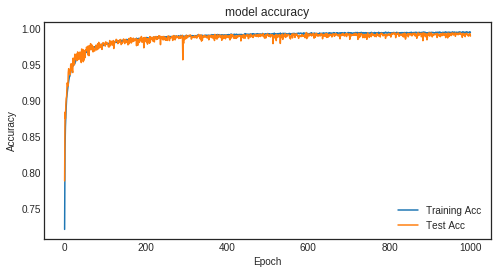

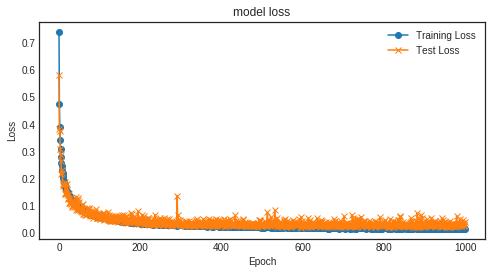

<Figure size 432x288 with 0 Axes>

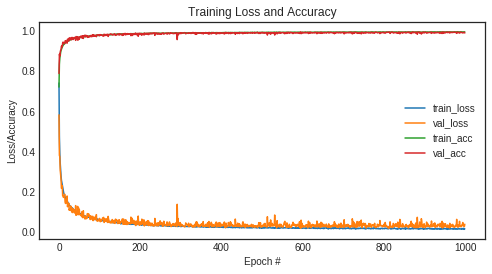

In [33]:
import seaborn
plt.style.use('seaborn-white')
plt.figure(figsize=(8,4))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='lower right')
plt.show()

# summarize history for loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'x-')
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper right')

plt.show()

plt.figure()
plt.figure(figsize=(8,4))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")

In [34]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

8339/8339 [==============================] - 1s 77us/step
Validation Accuracy: 98.9807%
Validation Loss: 0.03820486198455731


In [35]:
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score

preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.99096657633243


Confusion Matrix
[[417   0   0   1]
 [  1 136   4   0]
 [  3   0 371   1]
 [  0   0   0 173]]


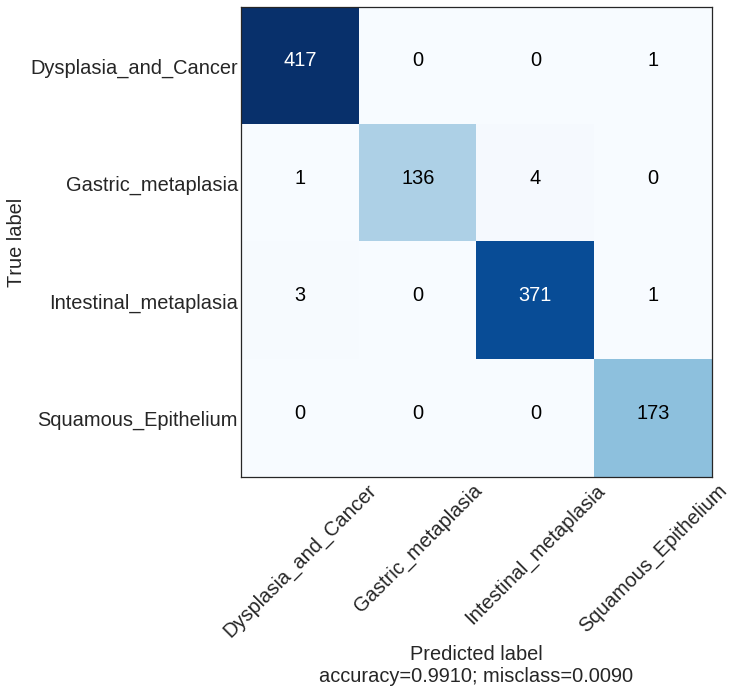

In [36]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[417   0   0   1]
 [  1 136   4   0]
 [  3   0 371   1]
 [  0   0   0 173]]
                       precision    recall  f1-score   support

 Dysplasia_and_Cancer       0.99      1.00      0.99       418
   Gastric_metaplasia       1.00      0.96      0.98       141
Intestinal_metaplasia       0.99      0.99      0.99       375
  Squamous_Epithelium       0.99      1.00      0.99       173

             accuracy                           0.99      1107
            macro avg       0.99      0.99      0.99      1107
         weighted avg       0.99      0.99      0.99      1107



In [38]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  99.76076555023924
Specificity :  100.0


In [39]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

1107/1107 [==============================] - 0s 70us/step
Precision =  0.991012972633968
Recall =  0.99096657633243
f1_score =  0.9909390785781349


In [40]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9932943381315397
